# Garbage Data Multi-Class Classification with EfficientNet

[Korean](01_garbage.ko-KR.ipynb) \| [English](01_garbage.en-US.ipynb) \| Copyright (c) 2023 [Jihoon Lucas Kim](https://github.com/kimnamu)

<a href="https://colab.research.google.com/github/kimnamu/cvnets/blob/master/demo/classfication/01_garbage.ko-KR.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>

이 notebook은 Custom Dataset으로 Image Classification 모델을 학습하는 과정을 다루고 있습니다.


# Process
1. Scoping : 문제정의
2. Data : 데이터 수집, 분석
3. Modeling : 적합한 모델 선정
4. Training : 데이터 학습
5. Analysis : 모델 분석 및 평가

## 1. Scoping (문제 정의)

- Garbage Image가 주어졌을 때 해당 Image가 어떤 Garbage인지를 분류합니다.
  - Input : Image File
  - Output : Garbage Class

## 2. Data (데이터 수집 및 분석)
- 데이터 수집은 최초 한번으로 끝나는 것이 아닌 이후 모델링, 학습, 평가 기간동안 계속해서 염두해야 합니다.
- 데이터 분석은 정량적, 정성적으로 살펴보아야 합니다.

### 2.1. Summary

- Dataset Download : https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification
- Dataset Tree
    ```
        Folder
        ├─garbage
        │  └─raw
        │     ├─glass     : 501 files
        │     ├─paper     : 594 files
        │     ├─cardboard : 403 files
        │     ├─plastic   : 482 files
        │     ├─metal     : 410 files
        │     └─trash     : 137 files
        ├─one-indexed-files-notrash_test.txt
        ...
        └─zero-indexed-files.txt
    ```
- Dataset Configuration
    - The number of images : 2527
    - The number of classes : 6
        - glass, paper, carboard, plastic, metal, trash
    - Average number of images per class : 421

### 2.2. Data Analysis

실제 데이터에 어떤 이미지가 있는지 살펴봅니다.

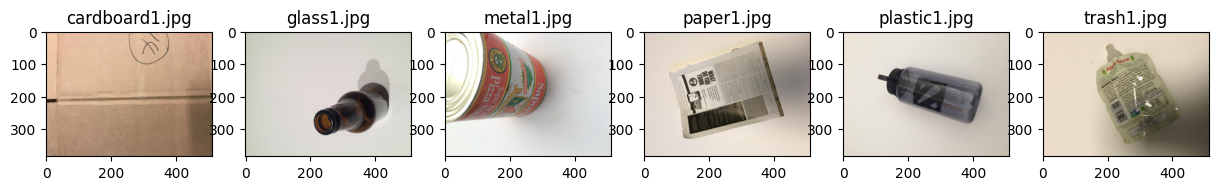

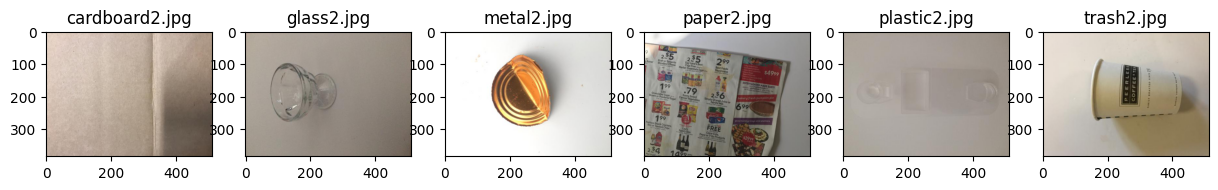

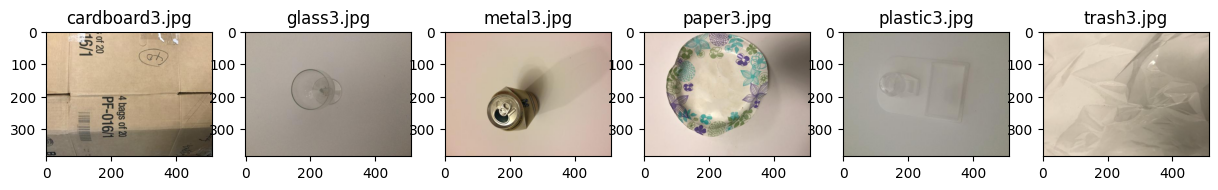

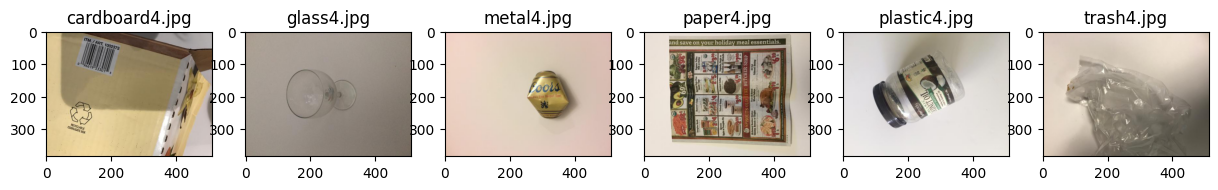

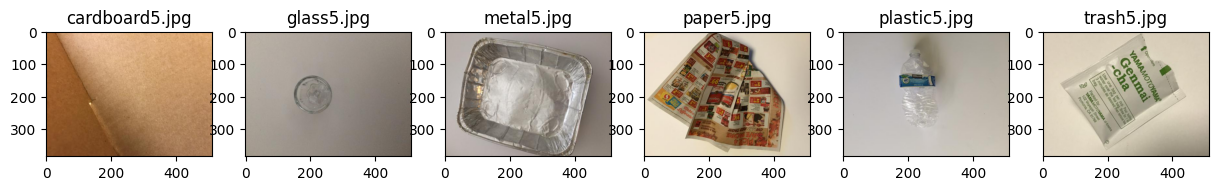

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image

dir_main = "../../data/garbage/"
phase = "raw"
classes = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

for i in range(5):
    image_paths = [f"{os.path.join(dir_main, phase, cls, cls+f'{i+1}.jpg')}" for cls in classes]
    images = [Image.open(image_path) for image_path in image_paths]

    fig, axes = plt.subplots(nrows=1, ncols=len(classes), figsize=(15,2))
    for idx, (cls, img) in enumerate(zip(classes, images)):
        axes[idx].set_title(f"{cls}{str(i+1)}.jpg")
        axes[idx].imshow(img)

### 2.3. Preprocessing dataset for train, validation and test

#### Preprare the dataset

In [ ]:
import os
import numpy as np
from glob import glob
from sklearn.model_selection import train_test_split
np.random.seed(724)

dir_main = "../../data/garbage/"
dir_data_original = os.path.join(dir_main, 'raw')
classes = glob(f"{dir_data_original}/*")
class_info = {idx : os.path.basename(cls) for idx, cls in enumerate(classes)}

img_files = glob(f"{dir_data_original}/*/*.jpg")
dataset = np.array([[img_file, img_file.split("/")[-2]] for img_file in img_files])

x = dataset[:,0]
y = dataset[:,1]
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7, random_state=724)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, train_size=0.5, random_state=724)

In [ ]:
def create_symlink(x_target, name='train'):
    for x in x_target:
        src = os.path.abspath(x)
        dst = src.replace("raw", name)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        if not os.path.exists(dst):
            os.symlink(src, dst)

create_symlink(x_train, "train")
create_symlink(x_test, "test")
create_symlink(x_val, "val")

def get_numbers(ys, cls=None):
    cls_cnt = {}
    for y in ys:
        if y not in cls_cnt.keys():
            cls_cnt[y]=0
        cls_cnt[y]+=1
    if cls is None:
        return cls_cnt
    return cls_cnt[cls]

print(f"Class\t\tTrain\tVal\tTest\n")
for cls in class_info.values():
    print(f"{cls:10}\t{get_numbers(y_train, cls)}\t{get_numbers(y_val, cls)}\t{get_numbers(y_test, cls)}")

Class		Train	Val	Test

paper     	410	79	105
metal     	292	56	62
cardboard 	287	61	55
trash     	85	31	21
glass     	341	88	72
plastic   	353	64	65


### 2.4. Create DataLoader

In [ ]:
import torch
from torch.utils.data import Dataset
from glob import glob

class GarbageDataset(Dataset): 
    def __init__(self, dir_dataset, tr):
        self.dir_dataset = os.path.abspath(dir_dataset)
        self.filelist = glob(self.dir_dataset + '/*/*.jpg')
        assert len(self.filelist)!=0, f"{self.dir_dataset + '/*/*.jpg'} is empty"
        self.classes = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
        self.tr = tr

    def get_image(self, filename):
        img = Image.open(filename)
        img = self.tr(img)
        return img

    def get_label(self, filename):
        label = np.array([0] * len(self.classes))
        cls = filename.split('/')[-2]
        label[self.classes.index(cls)] = 1
        return torch.from_numpy(label).type(torch.FloatTensor)

    def __getitem__(self, idx):
        filename = self.filelist[idx]
        img = self.get_image(filename)
        label = self.get_label(filename)
        return img, label

    def __len__(self): 
        return len(self.filelist)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl):
        self.dl = dl
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        
    def to_device(self, data):
        """Move tensor(s) to chosen device"""
        if isinstance(data, (list, tuple)):
            return [self.to_device(x, device) for x in data]
        return data.to(device, non_blocking=True)

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield self.to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


torchvision.transforms에는 다양한 변환 함수들이 포함되어 있습니다. 몇 가지 예를 들면 다음과 같습니다:

- Resize: 이미지 크기를 조정합니다.
- CenterCrop: 이미지의 중앙 부분을 잘라냅니다.
- RandomCrop: 이미지에서 무작위로 부분을 잘라냅니다.
- RandomHorizontalFlip: 이미지를 수평 방향으로 무작위로 뒤집습니다.
- RandomRotation: 이미지를 주어진 각도 범위 내에서 무작위로 회전시킵니다.
- ToTensor: 이미지 데이터를 PyTorch 텐서로 변환합니다.
- Normalize: 텐서를 주어진 평균 및 표준 편차 값으로 정규화합니다.

In [ ]:
from torch.utils.data import DataLoader
import torchvision.transforms as T

# print(model.default_cfg['mean']) # 'mean': (0.485, 0.456, 0.406)
# print(model.default_cfg['std']) # 'std': (0.229, 0.224, 0.225)
normalize = T.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

'''
Resize: 이미지 크기를 조정합니다.
CenterCrop: 이미지의 중앙 부분을 잘라냅니다.
RandomCrop: 이미지에서 무작위로 부분을 잘라냅니다.
RandomHorizontalFlip: 이미지를 수평 방향으로 무작위로 뒤집습니다.
RandomRotation: 이미지를 주어진 각도 범위 내에서 무작위로 회전시킵니다.
ToTensor: 이미지 데이터를 PyTorch 텐서로 변환합니다.
Normalize: 텐서를 주어진 평균 및 표준 편차 값으로 정규화합니다.
'''

train_tr = T.Compose([
    T.Resize((256, 256)),
    T.RandomCrop(224),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    normalize
])

test_tr = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    normalize
])

train_ds = GarbageDataset(os.path.join(dir_main, "train"), train_tr)
val_ds = GarbageDataset(os.path.join(dir_main, "val"), test_tr)
test_ds = GarbageDataset(os.path.join(dir_main, "test"), test_tr)

train_dl = DataLoader(train_ds, shuffle=True, num_workers=0, batch_size=64)
val_dl = DataLoader(val_ds, shuffle=True, num_workers=0, batch_size=64)
test_dl = DataLoader(test_ds, shuffle=True, num_workers=0, batch_size=64)

train_dl = DeviceDataLoader(train_dl)
val_dl = DeviceDataLoader(val_dl)
test_dl = DeviceDataLoader(test_dl)

### 3. Modeling

#### 3.1. Select Model - EfficientNet

EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks ([Paper](https://arxiv.org/abs/1905.11946)) 이란?

2019년에 나온 Architecture로 Google에서 Neural Architecture 최적화 기법 중 하나인 NAS(Neural Architecture Search)를 찾은 가성비 좋은 Scalable Architecture입니다.
Scalable한 이유는 NAS의 파라미터와 관련이 있습니다. 모델의 크기는 크게 아래 세가지 파라미터로 볼 수 있습니다.

<center><img src = "https://drive.google.com/uc?id=1dvD_KIiNVkj6ntF5QNo_LqfkK_xYLjQ4"  height = 300> </center>
Compound Scaling: EfficientNet은 Width, Depth, Resolution의 3가지 요소를 조절하여 모델의 성능과 효율성을 극대화합니다. 이를 Compound Scaling이라고 부르며, 이전에는 이 3가지 요소를 각각 조절하여 모델을 개발했지만, EfficientNet은 이를 종합적으로 고려하여 최적의 구조를 찾아냅니다.

1. Depth : 네트워크의 깊이로 레이어 수
2. Width : 각 레이어의 채널 수 
3. Resolution : input image의 해상도

<center><img src = "https://drive.google.com/uc?id=1DYrvKQN4Vlq_Pt6RjYKXQMWDIwgPtsRH" height = 400></center>
ImageNet에서 기존 ConvNet보다 8.4배 작으면서 6.1배 빠르고 더 높은 정확도를 갖는다.


<center><img src = "https://drive.google.com/uc?id=19Gq1NPLK333XQbRyEx9qlsNYS3k-xH8t" height = 300></center>
Efficient Blocks: Inverted Residual Block + SE(Squeeze-and-Excitation) Layer의 조합으로 되어있는데 이 구조는 모바일 기기에서도 빠르고 효율적이면서 높은 정확도를 갖게 해줍니다.

- ResNet과는 달리 Residual Connection 대신 Inverted Residual 구조를 기반으로 한 MBConv 레이어를 사용하여 정보 처리를 최적화하고, 네트워크의 크기와 계산 복잡도를 최소화하였습니다.
- SE Layer : 신경망 내의 채널 간의 상호 의존성을 모델링하기 위한 기법
  - Squeeze: 먼저,Global Average Pooling을 사용하여 각 채널별로 정보를 압축합니다. 이 과정에서 공간 정보는 손실되지만, 각 채널의 전반적인 통계 정보를 얻을 수 있습니다.
  - Excitation: Fully Connected Layer을 사용하여 각 채널의 중요성을 학습하는 파라미터를 도출합니다. 일반적으로, 첫 번째 Fully Connected Layer에서는 채널 수를 줄이는 역할을 하며(차원 축소), 두 번째 Fully Connected Layer에서는 activation fucntion을 통해 다시 원래의 채널 수로 복원합니다.
  - Scaling: 마지막으로, 학습된 채널 중요도를 원래의 feature map에 적용하여 각 채널별로 가중치를 조절합니다. 이 과정은 각 채널의 정보를 적절하게 강조하거나 약화시키는 데 도움이 됩니다.
  - SE Layer는 네트워크의 다양한 위치에 추가할 수 있으며, 많은 모델들이 이를 사용하여 성능을 향상시킵니다. 

#### 3.2. Package Installation

아래 package를 설치 합니다.
- [timm](https://github.com/rwightman/pytorch-image-models)

```
    pip install timm
```

#### 3.3. Loading Model

Timm에는 기존에 학습된 여러 pretrained 모델을 제공합니다.

In [ ]:
import timm

print(f"The number of pretrained models : {len(timm.list_models('*', pretrained=True))}")
timm.list_models('efficientnet*', pretrained=True)

The number of pretrained models : 770


['efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b1_pruned',
 'efficientnet_b2',
 'efficientnet_b2_pruned',
 'efficientnet_b3',
 'efficientnet_b3_pruned',
 'efficientnet_b4',
 'efficientnet_el',
 'efficientnet_el_pruned',
 'efficientnet_em',
 'efficientnet_es',
 'efficientnet_es_pruned',
 'efficientnet_lite0',
 'efficientnetv2_rw_m',
 'efficientnetv2_rw_s',
 'efficientnetv2_rw_t']

In [ ]:
model = timm.create_model('efficientnet_b0', pretrained=True)
model.default_cfg

{'url': 'https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth',
 'num_classes': 1000,
 'input_size': (3, 224, 224),
 'pool_size': (7, 7),
 'crop_pct': 0.875,
 'interpolation': 'bicubic',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'first_conv': 'conv_stem',
 'classifier': 'classifier',
 'architecture': 'efficientnet_b0'}

In [ ]:
# check output dimension
print(model.global_pool)
print(model.get_classifier())

SelectAdaptivePool2d (pool_type=avg, flatten=Flatten(start_dim=1, end_dim=-1))
Linear(in_features=1280, out_features=1000, bias=True)


In [ ]:
import torch

pool_types = ['avg', 'max', 'avgmax', 'catavgmax', '']

for pool in pool_types:
    model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=0, global_pool=pool)
    model.eval()
    feature_output = model(torch.randn(1, 3, 224, 224))
    print(feature_output.shape)

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


torch.Size([1, 1280])
torch.Size([1, 1280])
torch.Size([1, 1280])
torch.Size([1, 2560])
torch.Size([1, 1280, 7, 7])


In [ ]:
model.reset_classifier(len(classes), 'max')
print(model.global_pool)
print(model.get_classifier())

SelectAdaptivePool2d (pool_type=max, flatten=Flatten(start_dim=1, end_dim=-1))
Linear(in_features=1280, out_features=6, bias=True)


### change to custom fc

In [ ]:
num_in_features = model.get_classifier().in_features
num_in_features 

1280

In [ ]:
from torch import nn
model.fc = nn.Sequential(
    nn.BatchNorm1d(num_in_features),
    nn.Linear(in_features=num_in_features, out_features=512, bias=False),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.4),
    nn.Linear(in_features=512, out_features=6, bias=False)
)

In [ ]:
model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=len(classes), global_pool='avg')

In [ ]:
model.eval()
model(torch.randn(1, 3, 224, 224)).shape

torch.Size([1, 6])

In [ ]:
import timm
import torch.nn.functional as F

class EfficientNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=len(classes), global_pool='avg')
    
    def forward(self, x):
        return torch.sigmoid(self.model(x))

model = EfficientNet()
to_device(model, device)

## 4.Training

In [ ]:
import pickle
import os

class TrainHelper():
    def __init__(self, save_path='./ckpt/history.pickle', history=[]):
        self.history = history
        self.save_path = save_path
        os.makedirs(os.path.dirname(save_path), exist_ok=True)

    def accuracy(self, outputs, labels):
        pred = torch.max(outputs, dim=1)[1]
        gt = torch.max(labels, dim=1)[1]
        return torch.tensor(torch.sum(pred == gt).item() / len(pred))

    @torch.no_grad()
    def validation(self, batch):
        images, labels = batch 
        out = model(images)
        acc = self.accuracy(out, labels)
        loss = F.cross_entropy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    @torch.no_grad()
    def evaluation(self, model, data_loader):
        model.eval()
        outputs = [self.validation(batch) for batch in data_loader]
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': round(epoch_loss.item(), 5), 'val_acc': round(epoch_acc.item(), 5)}

    def logging(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        self.history.append(result)
        with open(self.save_path, 'wb') as f:
            pickle.dump(self.history, f)

train_helper = TrainHelper()

In [ ]:
train_helper.evaluation(model, val_dl)

{'val_loss': 1.28295, 'val_acc': 0.73932}

In [ ]:
from tqdm import tqdm

epochs = 20
optimizer = torch.optim.Adam(model.parameters(), 5.5e-5)
val_acc_best = 0
save_model_path = "./ckpt/"
os.makedirs(save_model_path, exist_ok=True)
for epoch in range(epochs):
    # Training Phase 
    model.train()
    train_losses = []
    for batch in tqdm(train_dl):
        inputs, targets = batch
        outputs = model(inputs)
        loss = F.cross_entropy(outputs, targets)

        train_losses.append(loss)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # Validation phase
    result = train_helper.evaluation(model, val_dl)
    result['train_loss'] = torch.stack(train_losses).mean().item()

    # Save the best model
    if result['val_acc'] >= val_acc_best:
        val_acc_best = result['val_acc']
        if 'save_model_name' in locals() and os.path.exists(save_model_name):
            os.remove(save_model_name)
        save_model_name = os.path.join(save_model_path, f"best_ep_{epoch}_{val_acc_best}.pt")
        torch.save(model.state_dict(), save_model_name)
        print(f"Saved PyTorch Model State to {save_model_name}")

    train_helper.logging(epoch, result)

# Save the last model
save_model_name = os.path.join(save_model_path, f"last_ep_{epoch}_{val_acc_best}.pt")
torch.save(model.state_dict(), save_model_name)

100%|██████████| 28/28 [02:30<00:00,  5.39s/it]


Saved PyTorch Model State to ./ckpt/best_ep_0_0.77816.pt
Epoch 0: train_loss: 1.2292, val_loss: 1.2568, val_acc: 0.7782


100%|██████████| 28/28 [02:31<00:00,  5.42s/it]


Saved PyTorch Model State to ./ckpt/best_ep_1_0.78381.pt
Epoch 1: train_loss: 1.2106, val_loss: 1.2389, val_acc: 0.7838


100%|██████████| 28/28 [02:30<00:00,  5.39s/it]


Saved PyTorch Model State to ./ckpt/best_ep_2_0.79749.pt
Epoch 2: train_loss: 1.1880, val_loss: 1.2309, val_acc: 0.7975


100%|██████████| 28/28 [02:30<00:00,  5.38s/it]


Saved PyTorch Model State to ./ckpt/best_ep_3_0.81616.pt
Epoch 3: train_loss: 1.1706, val_loss: 1.2200, val_acc: 0.8162


100%|██████████| 28/28 [02:31<00:00,  5.41s/it]


Saved PyTorch Model State to ./ckpt/best_ep_4_0.82071.pt
Epoch 4: train_loss: 1.1619, val_loss: 1.2120, val_acc: 0.8207


100%|██████████| 28/28 [02:31<00:00,  5.40s/it]


Saved PyTorch Model State to ./ckpt/best_ep_5_0.83589.pt
Epoch 5: train_loss: 1.1525, val_loss: 1.2102, val_acc: 0.8359


100%|██████████| 28/28 [02:28<00:00,  5.32s/it]


Saved PyTorch Model State to ./ckpt/best_ep_6_0.84437.pt
Epoch 6: train_loss: 1.1403, val_loss: 1.2054, val_acc: 0.8444


100%|██████████| 28/28 [02:33<00:00,  5.47s/it]


Saved PyTorch Model State to ./ckpt/best_ep_7_0.84913.pt
Epoch 7: train_loss: 1.1393, val_loss: 1.2022, val_acc: 0.8491


100%|██████████| 28/28 [02:30<00:00,  5.38s/it]


Saved PyTorch Model State to ./ckpt/best_ep_8_0.85434.pt
Epoch 8: train_loss: 1.1305, val_loss: 1.1980, val_acc: 0.8543


100%|██████████| 28/28 [02:30<00:00,  5.39s/it]


Saved PyTorch Model State to ./ckpt/best_ep_9_0.87129.pt
Epoch 9: train_loss: 1.1182, val_loss: 1.1873, val_acc: 0.8713


100%|██████████| 28/28 [02:29<00:00,  5.35s/it]


Epoch 10: train_loss: 1.1100, val_loss: 1.1886, val_acc: 0.8709


100%|██████████| 28/28 [02:30<00:00,  5.36s/it]


Epoch 11: train_loss: 1.1138, val_loss: 1.1916, val_acc: 0.8626


100%|██████████| 28/28 [02:28<00:00,  5.32s/it]


Epoch 12: train_loss: 1.1027, val_loss: 1.1839, val_acc: 0.8652


100%|██████████| 28/28 [02:30<00:00,  5.37s/it]


Epoch 13: train_loss: 1.1006, val_loss: 1.1826, val_acc: 0.8709


100%|██████████| 28/28 [02:29<00:00,  5.35s/it]


Saved PyTorch Model State to ./ckpt/best_ep_14_0.88431.pt
Epoch 14: train_loss: 1.0967, val_loss: 1.1743, val_acc: 0.8843


100%|██████████| 28/28 [02:30<00:00,  5.38s/it]


Saved PyTorch Model State to ./ckpt/best_ep_15_0.88626.pt
Epoch 15: train_loss: 1.0910, val_loss: 1.1749, val_acc: 0.8863


100%|██████████| 28/28 [02:32<00:00,  5.44s/it]


Epoch 16: train_loss: 1.0934, val_loss: 1.1819, val_acc: 0.8778


100%|██████████| 28/28 [02:29<00:00,  5.33s/it]


Epoch 17: train_loss: 1.0832, val_loss: 1.1795, val_acc: 0.8765


100%|██████████| 28/28 [02:28<00:00,  5.29s/it]


Epoch 18: train_loss: 1.0840, val_loss: 1.1762, val_acc: 0.8813


100%|██████████| 28/28 [02:28<00:00,  5.29s/it]


Epoch 19: train_loss: 1.0845, val_loss: 1.1684, val_acc: 0.8841


##### Train & Validation Losses

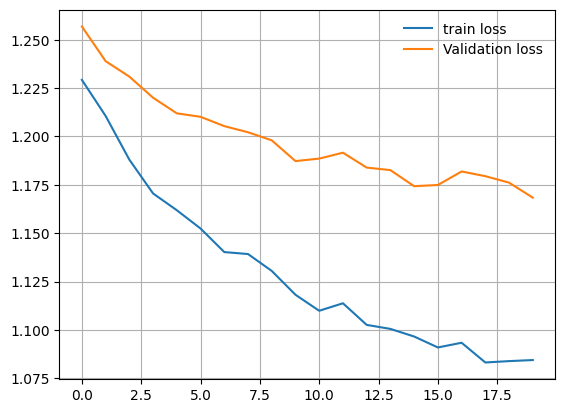

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

train_loss = [history['train_loss'] for history in train_helper.history]
val_loss = [history['val_loss'] for history in train_helper.history]

plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label='Validation loss')
plt.grid()
plt.legend(frameon=False)

##### Accuracy

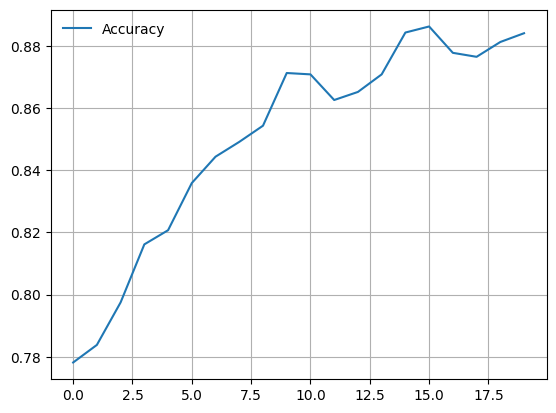

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

val_acc = [history['val_acc'] for history in train_helper.history]
plt.plot(val_acc, label='Accuracy')
plt.grid()
plt.legend(frameon=False)

## 5. Analysis

##### Confusion Matrix

100%|██████████| 6/6 [00:11<00:00,  1.98s/it]

Classes : ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Performance 
              precision    recall  f1-score   support

           0      0.962     0.909     0.935        55
           1      0.925     0.861     0.892        72
           2      0.912     0.839     0.874        62
           3      0.874     0.990     0.929       105
           4      0.836     0.938     0.884        65
           5      1.000     0.571     0.727        21

    accuracy                          0.897       380
   macro avg      0.918     0.852     0.873       380
weighted avg      0.903     0.897     0.895       380



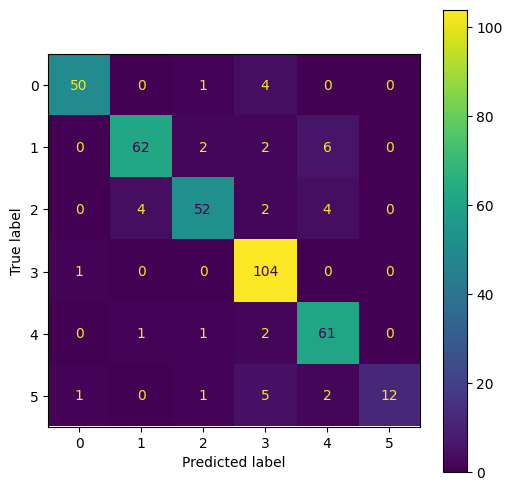

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt

model.eval()

y_pred = []
y_true = []
for batch in tqdm(test_dl):
    inputs, targets = batch
    outputs = model(inputs)
    y_pred.extend(torch.max(outputs, dim=1)[1].numpy())
    y_true.extend(torch.max(targets, dim=1)[1].numpy())

performance = metrics.classification_report(y_true, y_pred, digits=3)
confusion_matrix = metrics.confusion_matrix(y_true, y_pred)

classes = test_ds.classes
disp = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = list(range(len(classes))))
print(f"Classes : {classes}")
print(f"Performance \n{performance}")

disp.plot()
fig = disp.ax_.get_figure() 
fig.set_figwidth(len(classes))
fig.set_figheight(len(classes)) 
plt.savefig("confusion_matrix.jpg")
plt.show()

#### Load Trained Model

In [ ]:
import torch

model=EfficientNet()
model.load_state_dict(torch.load("./ckpt/best_ep_15_0.88626.pt", map_location='cpu'))

<All keys matched successfully>

In [ ]:
# Recovery of normalized image dataset for visualization
normalize_inverted = T.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

#### False Positive Cases

False Positive Cases


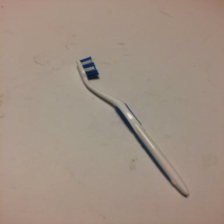

Prediction   : paper (0.9234)
Ground Truth : trash


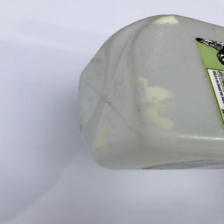

Prediction   : metal (0.5817)
Ground Truth : plastic


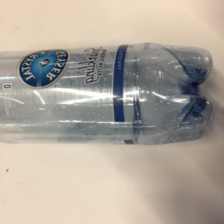

Prediction   : glass (0.9909)
Ground Truth : plastic


In [ ]:
from IPython.display import display
from PIL import Image
FP = 3
for data in test_dl:
    if FP==0:
        break
    img_batch, label_batch = data
    results = model(img_batch)
    confs, preds = torch.max(results, dim=1)
    _, gts = torch.max(label_batch, dim=1)
    preds = preds.numpy()
    confs = confs.detach().numpy()
    gts = gts.numpy()
    
    for img, p, conf, g in zip(img_batch, preds, confs, gts):
        if FP <= 0:
            break
        x = normalize_inverted(img).numpy()
        x = (x * 255).astype(np.uint8).T
        x = Image.fromarray(x)
        if p!=g:
            display(x)
            print(f"Prediction   : {test_ds.classes[p]} ({conf:0.4f})")
            print(f"Ground Truth : {test_ds.classes[g]}")
            FP -= 1


#### True Positive Cases (Low confidence, Edge case)

True Positive Cases


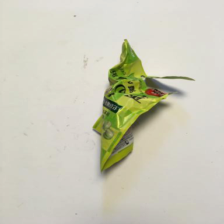

Prediction   : plastic (0.0405)
Ground Truth : plastic


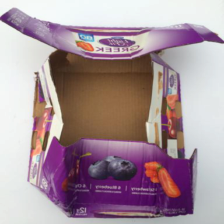

Prediction   : cardboard (0.3249)
Ground Truth : cardboard


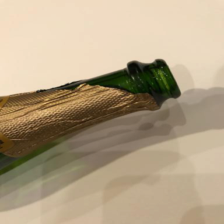

Prediction   : glass (0.2564)
Ground Truth : glass


In [ ]:
TP = 3
for data in test_dl:
    if TP <= 0:
        break
    img_batch, label_batch = data
    results = model(img_batch)
    confs, preds = torch.max(results, dim=1)
    _, gts = torch.max(label_batch, dim=1)
    preds = preds.numpy()
    confs = confs.detach().numpy()
    gts = gts.numpy()
    
    for img, p, conf, g in zip(img_batch, preds, confs, gts):
        x = normalize_inverted(img).numpy()
        x = (x * 255).astype(np.uint8).T
        x = Image.fromarray(x)
        if p==g and conf < 0.5:
            display(x)
            print(f"Prediction   : {test_ds.classes[p]} ({conf:0.4f})")
            print(f"Ground Truth : {test_ds.classes[g]}")
            TP -= 1